# Machine Learning for Population Forecasting and Critical Habitat Protection.

### Overview
This notebook provides an analysis of Western Monarch butterfly overwintering data using statistics and machine learning techniques. 

**Importance**
Monarchs are vital pollinators supporting biodiversity across western North America. Their annual journey represents one of nature's most fascinating navigational feats.

**Conservation Urgency**
Once numbering in the millions during the 1980s, the population has diminished by over 95%, with recent counts showing approximately 30,000 butterflies. The species has been listed as "**Endangered" since 2022.

We analyze three distinct datasets:
- Sites Dataset: Geographic and site characteristics
- Counts Dataset: Butterfly observation counts over time
- Joined Dataset: Combined sites and counts for comprehensive analysis



In [1]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Machine learning libraries
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.impute import SimpleImputer

#plt.style.use('seaborn-v0_8')
#sns.set_pallette('husl')

In [2]:
# Utility Functions
def print_heading(heading):
    print("\n" + "="*60)
    print(heading)
    print("="*60)

# Function to print brief info for the given DataFrame object and column
def print_col_info(df, col):
    print(f"\nColumn: {col}")
    print(df[col].value_counts(normalize=True, sort=True, ascending=False))
    print(f"Unique values: {df[col].nunique()}")
    print(f"Most frequent: {df[col].mode()}\n")

### Load Sites and Counts Datasets

In [3]:
print_heading("Loading Western Monarch Datasets")

sites_df = pd.read_csv('data/sites_2025.csv')
counts_df = pd.read_csv('data/counts_2025.csv')

print(f"Sites dataset: {sites_df.shape[0]:,} rows x {sites_df.shape[1]} columns")
print(f"Counts dataset: {counts_df.shape[0]:,} rows x {counts_df.shape[1]} columns")


Loading Western Monarch Datasets
Sites dataset: 526 rows x 11 columns
Counts dataset: 11,175 rows x 34 columns


### Understanding the Data

##### Display shape and overview

In [4]:
print_heading("Dataset Overview")

print("\nSites Info")
print("="*20)
print(sites_df.info())

print("\n\nCounts Info")
print("="*20)
print(counts_df.info())

print("\n\nSites Describe")
print("="*20)
print(sites_df.describe())
print("\n\nCounts Describe")
print("="*20)
print(counts_df.describe())
print("="*20)


Dataset Overview

Sites Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OBJECTID          526 non-null    int64  
 1   GlobalID          526 non-null    object 
 2   SiteID            526 non-null    int64  
 3   Region            526 non-null    object 
 4   Region ID         526 non-null    object 
 5   Site Status       525 non-null    object 
 6   CNDDB EO          320 non-null    float64
 7   Boundary Quality  524 non-null    object 
 8   WMC Site          522 non-null    object 
 9   Latitude          510 non-null    float64
 10  Longitude         510 non-null    float64
dtypes: float64(3), int64(2), object(6)
memory usage: 45.3+ KB
None


Counts Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11175 entries, 0 to 11174
Data columns (total 34 columns):
 #   Column                     Non-Null Count  Dtype  
---  --

##### Standardize Columns: `snake_case`

In [5]:
def standardize_column_names(df):
    df_copy = df.copy()
    df_copy.columns = (df_copy.columns.str.lower()
                                      .str.replace(' ', '_')
                                      .str.replace('(', '')
                                      .str.replace(')', '')
                                      .str.replace('-', '_'))
    return df_copy
    
print_heading("Standardize to snake_case")

print(f"\nOriginal Sites columns: {sites_df.columns.tolist()[:7]} ...")
print(f"Original Counts columns: {counts_df.columns.tolist()[:7]} ...\n\n")
sites_df = standardize_column_names(sites_df)
counts_df = standardize_column_names(counts_df)
print(f"Standardized Sites columns: {sites_df.columns.tolist()[:7]}")
print(f"Standardized Counts columns: {counts_df.columns.tolist()[:7]}")


Standardize to snake_case

Original Sites columns: ['OBJECTID', 'GlobalID', 'SiteID', 'Region', 'Region ID', 'Site Status', 'CNDDB EO'] ...
Original Counts columns: ['ObjectID', 'Observation ID', 'GlobalID', 'Source ID', 'Verbatim Observation Date', 'Observation Date', 'Count Start Time'] ...


Standardized Sites columns: ['objectid', 'globalid', 'siteid', 'region', 'region_id', 'site_status', 'cnddb_eo']
Standardized Counts columns: ['objectid', 'observation_id', 'globalid', 'source_id', 'verbatim_observation_date', 'observation_date', 'count_start_time']


##### Data Cleaning and Quality Assement

**Missing Values**

In [6]:
def display_missing_values(df, name): 
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100).round(1)
    missing_summary = pd.DataFrame({
        'Missing_Count': missing,
        'Missing_Percent': missing_pct
    })
    missing_summary = missing_summary.sort_values('Missing_Percent', ascending=False)

    print(f"Missing values in {missing_summary.shape[0]} columns:")
    print(f"Missing values: {missing_summary.sort_values('Missing_Percent', ascending=True)}")

    return missing_summary

print_heading("Data Quality Assessment -- Sites Dataset")
sites_quality = display_missing_values(sites_df, 'Sites')

print_heading("Data Quality Assessment -- Counts Dataset")
counts_quality = display_missing_values(counts_df, 'Counts')




Data Quality Assessment -- Sites Dataset
Missing values in 11 columns:
Missing values:                   Missing_Count  Missing_Percent
objectid                      0              0.0
globalid                      0              0.0
siteid                        0              0.0
region                        0              0.0
region_id                     0              0.0
site_status                   1              0.2
boundary_quality              2              0.4
wmc_site                      4              0.8
latitude                     16              3.0
longitude                    16              3.0
cnddb_eo                    206             39.2

Data Quality Assessment -- Counts Dataset
Missing values in 34 columns:
Missing values:                            Missing_Count  Missing_Percent
objectid                               0              0.0
globalid                               0              0.0
source_id                              0              0.0
obs

**Data Filtering**

In [7]:
print_heading("Data Filtering")

print(f"Initial Sites dataset: {sites_df.shape[0]:,} rows")
print(f"Initial Counts dataset: {counts_df.shape[0]:,} rows")

print("\nFiltering...\n")
# Drop rows with missing geo coordinates
sites_filtered = sites_df.dropna(subset=['latitude', 'longitude'])

# Drop rows in counts data without site_id
counts_filtered = counts_df.dropna(subset=['observation_date', 'site_id'])

sites_df = sites_filtered.copy()
counts_df = counts_filtered.copy()

print(f"Initial Sites dataset: {sites_df.shape[0]:,} rows")
print(f"Initial Counts dataset: {counts_df.shape[0]:,} rows")


Data Filtering
Initial Sites dataset: 526 rows
Initial Counts dataset: 11,175 rows

Filtering...

Initial Sites dataset: 510 rows
Initial Counts dataset: 11,074 rows


##### Target Variable Analysis

In [8]:
print_heading("Target Variable: grand_total")

grand_total = counts_df['grand_total'].dropna()
print(counts_df['grand_total'].describe())

print(f"\nDistribution Analysis:")
print(f"Zero counts: {(grand_total == 0).sum():,} ({(grand_total == 0).mean()*100:.1f}%)")
print(f"Low counts (1-10): {((grand_total > 0) & (grand_total <= 10)).sum():,}")
print(f"Medium counts (11-100): {((grand_total > 10) & (grand_total <= 100)).sum():,}")
print(f"High counts (101-1000): {((grand_total > 100) & (grand_total <= 1000)).sum():,}")
print(f"Very high counts (>1000): {(grand_total > 1000).sum():,}")



Target Variable: grand_total
count     10592.000000
mean       1632.259347
std        7201.705914
min           0.000000
25%           0.000000
50%           6.000000
75%         287.500000
max      200000.000000
Name: grand_total, dtype: float64

Distribution Analysis:
Zero counts: 3,846 (36.3%)
Low counts (1-10): 1,980
Medium counts (11-100): 1,569
High counts (101-1000): 1,411
Very high counts (>1000): 1,786


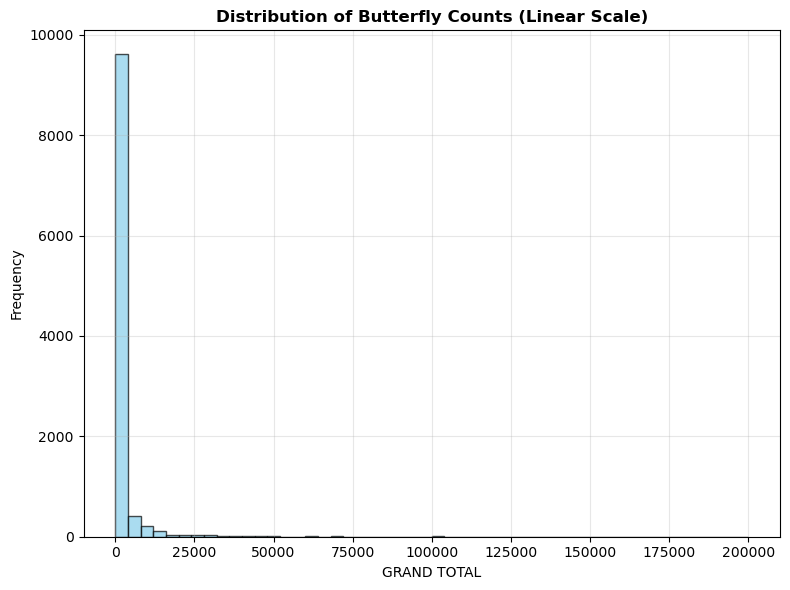

In [9]:
plt.figure(figsize=(8, 6))
plt.hist(grand_total, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribution of Butterfly Counts (Linear Scale)', fontweight='bold')
plt.xlabel('GRAND TOTAL')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

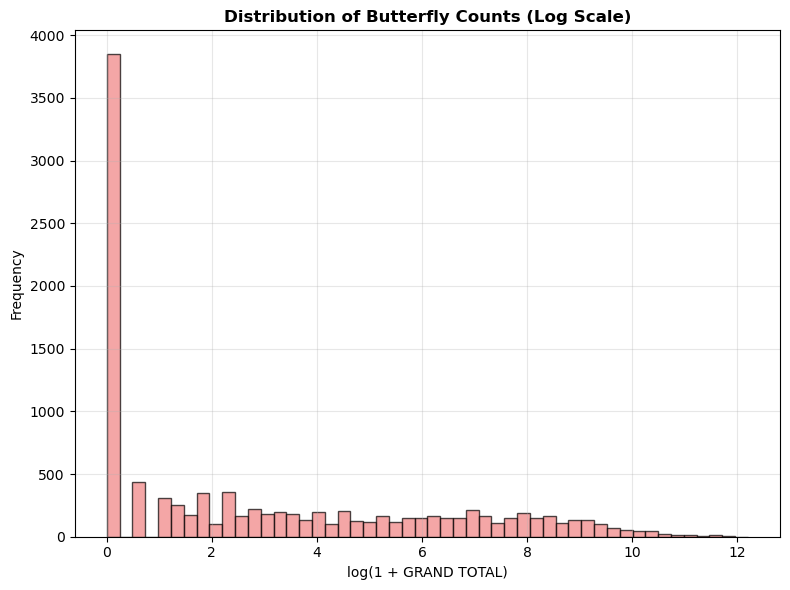

In [10]:
# Log-scale histogram
log_counts = np.log1p(grand_total)

plt.figure(figsize=(8, 6))
plt.hist(log_counts, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.title('Distribution of Butterfly Counts (Log Scale)', fontweight='bold')
plt.xlabel('log(1 + GRAND TOTAL)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

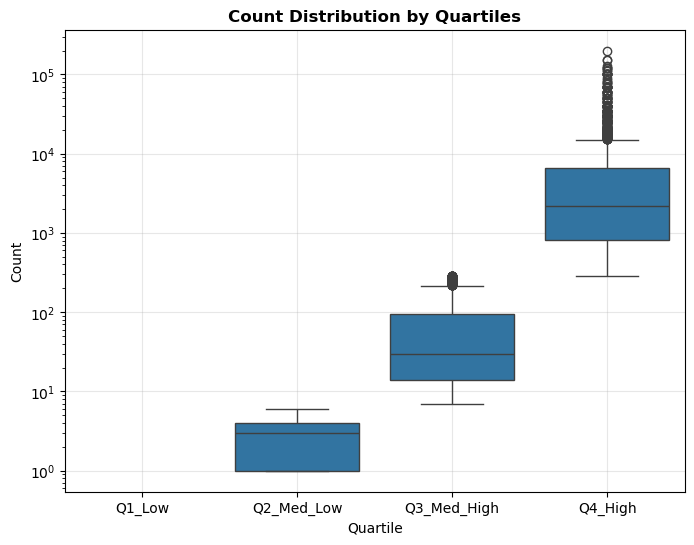

In [11]:
# Boxplot by quantiles
quantiles = grand_total.quantile([0.25, 0.5, 0.75]).values
count_quartiles = pd.cut(grand_total, 
                        bins=[-np.inf] + list(quantiles) + [np.inf],
                        labels=['Q1_Low', 'Q2_Med_Low', 'Q3_Med_High', 'Q4_High'])

quartile_data = pd.DataFrame({'Count': grand_total, 'Quartile': count_quartiles})

plt.figure(figsize=(8,6))
sns.boxplot(data=quartile_data, x='Quartile', y='Count')
plt.title('Count Distribution by Quartiles', fontweight='bold')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.show()

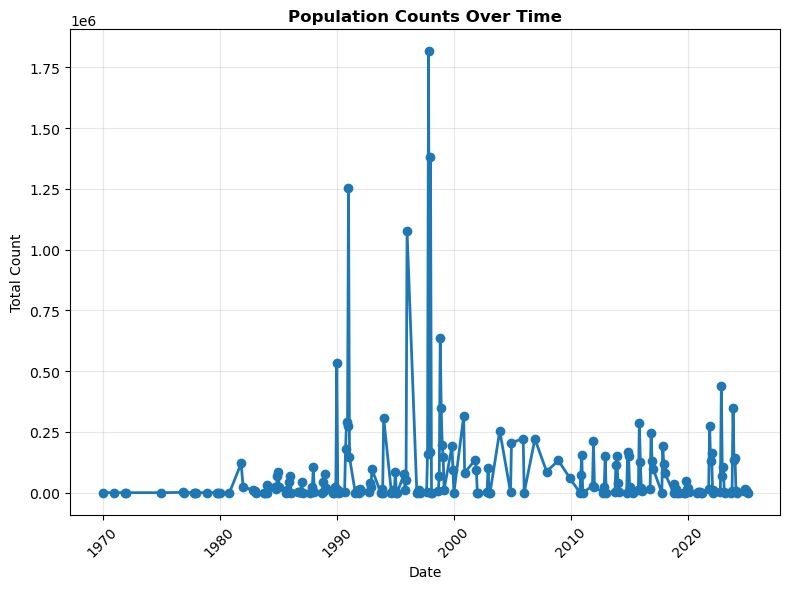

In [12]:
# Time series plot
counts_df['observation_date'] = pd.to_datetime(counts_df['observation_date'], errors='coerce')
monthly_totals = counts_df.groupby(counts_df['observation_date'].dt.to_period('M'))['grand_total'].sum()

plt.figure(figsize=(8,6))
plt.plot(monthly_totals.index.to_timestamp(), monthly_totals.values, marker='o', linewidth=2)
plt.title('Population Counts Over Time', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Total Count')
plt.grid(True, alpha=0.3)
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

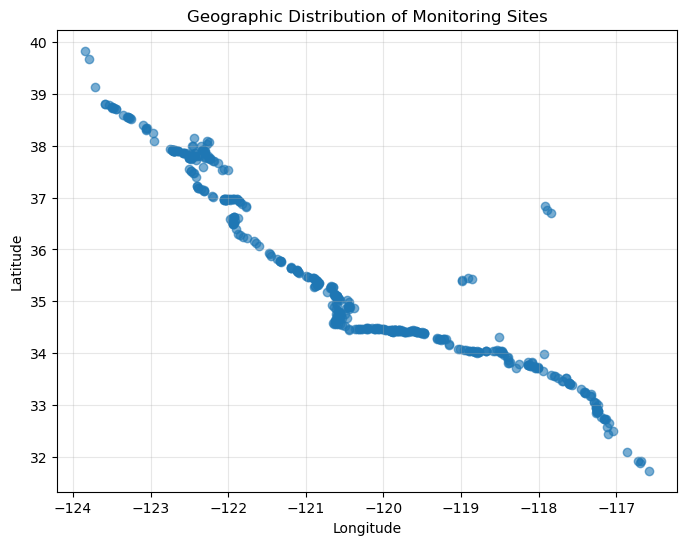

In [13]:
# Plot geographic distribution
plt.figure(figsize=(8, 6))
plt.scatter(sites_df['longitude'], sites_df['latitude'], alpha=0.6)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Geographic Distribution of Monitoring Sites')
plt.grid(True, alpha=0.3)
plt.show()

### Feature Engineering and Data Preparation

In [14]:
print_heading("Feature Engineering")

print("\nFeatures added to Sites DataFrame:")
# determine geographic region with latitude
sites_df['geo_region'] = pd.cut(sites_df['latitude'], 
                                    bins=3, 
                                    labels=['Southern', 'Central', 'Northern'])
print(f"  Created geo_region feature with {sites_df['geo_region'].nunique()} categories")

print("\nFeatures added to Counts DataFrame")
counts_df['observation_date'] = pd.to_datetime(counts_df['observation_date'], errors='coerce')

count_col = "grand_total"
counts_df[count_col] = pd.to_numeric(counts_df[count_col], errors='coerce')
counts_df[count_col] = counts_df[count_col].fillna(0)

# log transformed target
counts_df['log_count'] = np.log1p(counts_df[count_col])
print(f"  Created log_count feature with (log(1 + count))")

counts_df['has_count'] = (counts_df[count_col] > 0).astype(int)
print(f"  Created has_count binary feature")

counts_df['count_magnitude'] = pd.cut(counts_df[count_col], 
                                          bins=[0, 1, 10, 100, 1000, float('inf')], 
                                          labels=['zero', 'very_low', 'low', 'medium', 'high'])
print(f"  Created count_magnitude feature\n")


Feature Engineering

Features added to Sites DataFrame:
  Created geo_region feature with 3 categories

Features added to Counts DataFrame
  Created log_count feature with (log(1 + count))
  Created has_count binary feature
  Created count_magnitude feature



In [15]:
print_heading("Prepare Sites Data for Modeling")
ml_sites_df = sites_df.copy()

feature_cols = []
feature_cols.append('latitude')
feature_cols.append('longitude')
feature_cols.append('geo_region')

# Encode categorical features
le = LabelEncoder()

ml_sites_df['region_encoded'] = le.fit_transform(ml_sites_df['region'].astype(str))
feature_cols.append('region_encoded')

# Create target variable (site activity level based on geographic clustering)
if 'latitude' in ml_sites_df.columns and 'longitude' in ml_sites_df.columns:
    coords = ml_sites_df[['latitude', 'longitude']].values
    kmeans = KMeans(n_clusters=3, random_state=42)
    ml_sites_df['activity_level'] = kmeans.fit_predict(coords)

X_sites = ml_sites_df[feature_cols]
y_sites = ml_sites_df['activity_level']

print(f"Sites ML dataset: {X_sites.shape if X_sites is not None else 'None'}")
print(f"Columns in sites ML dataset: {X_sites.columns}")


Prepare Sites Data for Modeling
Sites ML dataset: (510, 4)
Columns in sites ML dataset: Index(['latitude', 'longitude', 'geo_region', 'region_encoded'], dtype='object')


In [16]:
print_heading("Prepare Counts Data for Modeling")
ml_counts_df = counts_df.copy()

feature_cols = []

date_col = "observation_date"
ml_counts_df['year'] = ml_counts_df[date_col].dt.year
ml_counts_df['month'] = ml_counts_df[date_col].dt.month
ml_counts_df['day_of_year'] = ml_counts_df[date_col].dt.dayofyear
feature_cols.extend(['year', 'month', 'day_of_year'])

target = ml_counts_df['log_count']

X_counts = ml_counts_df[feature_cols]
y_counts = target

print(f"Counts ML dataset: {X_counts.shape}")
print(f"Columns in sites ML dataset: {X_counts.columns}")



Prepare Counts Data for Modeling
Counts ML dataset: (11074, 3)
Columns in sites ML dataset: Index(['year', 'month', 'day_of_year'], dtype='object')


In [17]:
print_heading("Merge Sites and counts datasets")

joined_df = pd.merge(ml_sites_df, ml_counts_df,
                    left_on='siteid',
                    right_on='site_id',
                    how='inner')

# Remove rows with missing target variable
joined_df = joined_df.dropna(subset=['log_count'])

feature_cols = []
feature_cols.append('latitude')
feature_cols.append('longitude')
feature_cols.append('geo_region')

count_col = "grand_total"
joined_df['log_count'] = np.log1p(joined_df[count_col])
feature_cols.append('log_count')

date_col = "observation_date"
joined_df[date_col] = pd.to_datetime(joined_df[date_col], errors='coerce')
joined_df['month'] = joined_df[date_col].dt.month
feature_cols.append('month')

X_joined = joined_df[feature_cols]
y_joined = joined_df['log_count']

print(f"\nJoined ML dataset: {X_joined.shape}")
print(f"Columns in joined ML dataset: {X_joined.columns}")


Merge Sites and counts datasets

Joined ML dataset: (10896, 5)
Columns in joined ML dataset: Index(['latitude', 'longitude', 'geo_region', 'log_count', 'month'], dtype='object')


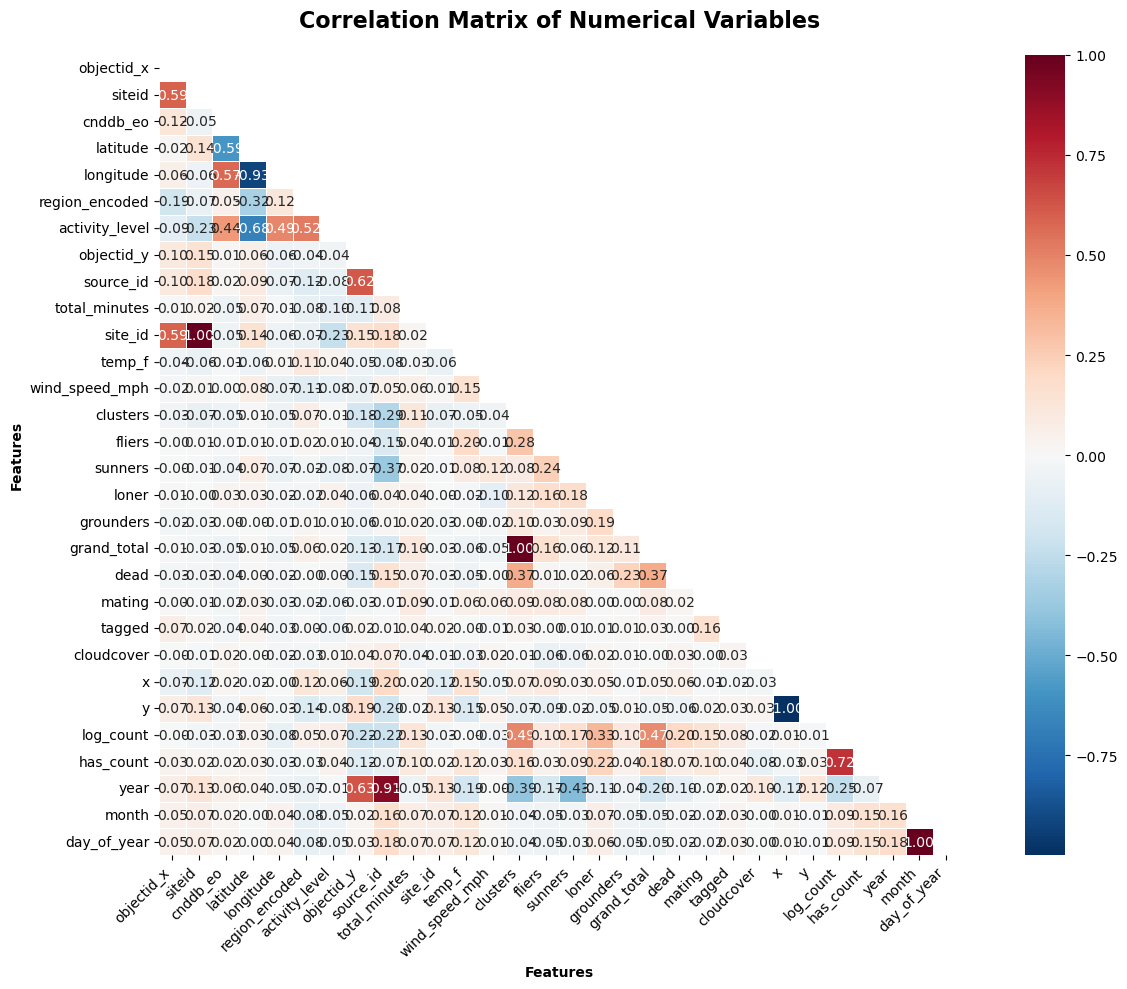

In [18]:
# Correlation Analysis
numerical_data = joined_df.select_dtypes(include=["float64", "int32", "int64"])
correlation_matrix = numerical_data.corr()

plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # mask upper
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', 
                      center=0, square=True, fmt='.2f', 
                      linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Features', fontweight='bold')
plt.ylabel('Features', fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Train and Evaluate Models


In [19]:
print_heading("Regression Baseline Model")
categorical_features = []
numerical_features = []

for col in X_joined.columns:
    if X_joined[col].dtype == 'object' or X_joined[col].dtype.name == 'category':
        categorical_features.append(col)
    else:
        numerical_features.append(col)

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X_joined, y_joined, test_size=0.2, random_state=42
)

print(f"\nTrain / Test split:")
print(f"Training set: {X_train.shape[0]} observations")
print(f"Test set: {X_test.shape[0]} observations")


Regression Baseline Model
Numerical features: ['latitude', 'longitude', 'log_count', 'month']
Categorical features: ['geo_region']

Train / Test split:
Training set: 8716 observations
Test set: 2180 observations


In [20]:
print_heading("Multiple Regression Models Training and Comparison")
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor

models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Support Vector Regression': SVR(kernel='rbf', C=1.0, gamma='scale')
}

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])
    
    # Trainning
    pipeline.fit(X_train, y_train)
    
    # Make predictions
    y_pred_train = pipeline.predict(X_train)
    y_pred_test = pipeline.predict(X_test)
    
    # Calculate metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    train_mae = mean_absolute_error(y_train, y_pred_train)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    
    results[name] = {
        'model': pipeline,
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae,
        'predictions': y_pred_test
    }
    
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
    print(f"  Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

print(f"\nBest model by Test R²: {max(results.items(), key=lambda x: x[1]['test_r2'])[0]}")


Multiple Regression Models Training and Comparison

Training Linear Regression...
  Train R²: 1.0000, Test R²: 1.0000
  Train RMSE: 0.0000, Test RMSE: 0.0000
  Train MAE: 0.0000, Test MAE: 0.0000

Training Random Forest...
  Train R²: 1.0000, Test R²: 1.0000
  Train RMSE: 0.0015, Test RMSE: 0.0041
  Train MAE: 0.0002, Test MAE: 0.0006

Training Support Vector Regression...
  Train R²: 0.9996, Test R²: 0.9995
  Train RMSE: 0.0657, Test RMSE: 0.0710
  Train MAE: 0.0533, Test MAE: 0.0537

Best model by Test R²: Linear Regression



Model Performance Comparison and Visualization


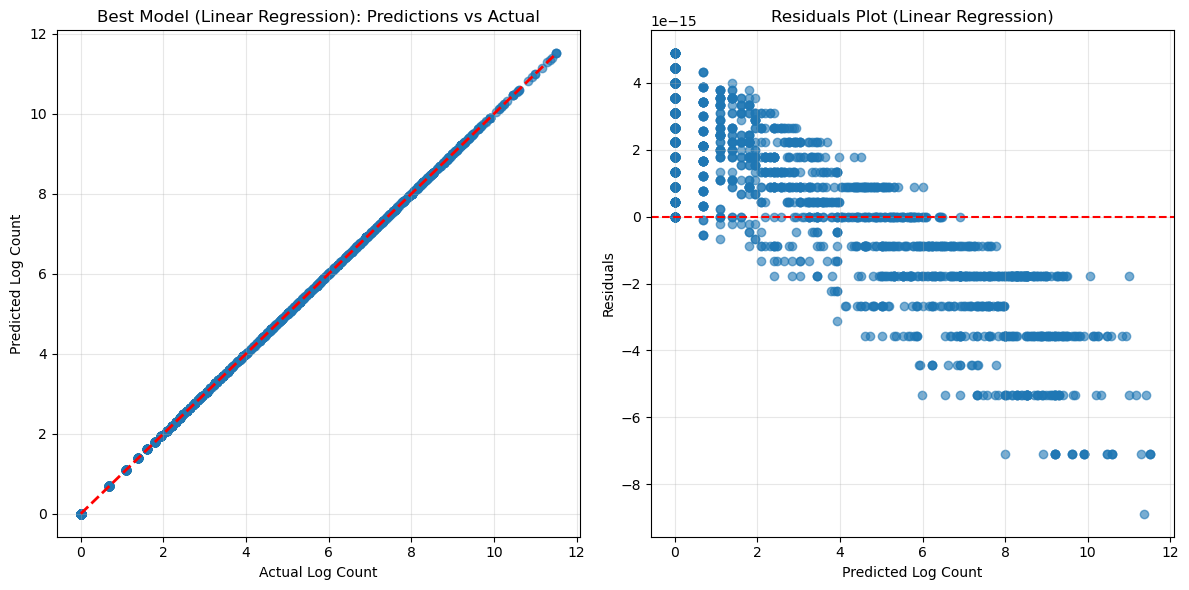

In [21]:
print_heading("Model Performance Comparison and Visualization")

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Best model predictions vs actual
best_model_name = max(results.items(), key=lambda x: x[1]['test_r2'])[0]
best_predictions = results[best_model_name]['predictions']

axes[0].scatter(y_test, best_predictions, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Log Count')
axes[0].set_ylabel('Predicted Log Count')
axes[0].set_title(f'Best Model ({best_model_name}): Predictions vs Actual')
axes[0].grid(True, alpha=0.3)

# Residuals plot
residuals = y_test - best_predictions
axes[1].scatter(best_predictions, residuals, alpha=0.6)
axes[1].axhline(y=0, color='r', linestyle='--')
axes[1].set_xlabel('Predicted Log Count')
axes[1].set_ylabel('Residuals')
axes[1].set_title(f'Residuals Plot ({best_model_name})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
